In [2]:
# !pip install opendatasets
# !pip install pandas
# !pip install seaborn

### Importing packages and notebook config

In [3]:
import opendatasets as op
import pandas as pd
import numpy as np

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
import seaborn as sns 
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (24,16)})
rcParams['figure.figsize'] = 24,16

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Download of data

In [5]:
op.download("https://www.kaggle.com/airbnb/boston")

Skipping, found downloaded files in "./boston" (use force=True to force download)


### Importing data

In [6]:
calendar = pd.read_csv('boston/calendar.csv') 
listings = pd.read_csv('boston/listings.csv')
reviews = pd.read_csv('boston/reviews.csv')

In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [8]:
def price_to_numeric(price):
    """
    Arg: string that refers to price
    Return: price as float
    
    Function that receives the price as a string and transforms it into a float
    """
    try:
        return float(price[1:].replace(',',''))
    except:
        return None


calendar['price'] = calendar['price'].map(price_to_numeric)

### How is the price related to geolocation?

Certainly, geolocation is one of the most important features related to price. The following visualization shows the spatial distribution of the median prices associated with each listing_id.

In [ ]:
price_groupby_listing_id = calendar[['listing_id', 'price']].groupby(by=['listing_id']) \
                                                            .median() \
                                                            .reset_index() \
                                                            .rename(columns = {'listing_id': 'id'})
listing_geoloc_info = listings[['id','latitude', 'longitude']].copy()
median_price_by_geoloc = listing_geoloc_info.merge(price_groupby_listing_id, how='left', on='id')

Removing outliers:

In [9]:
def calcOutliersRange(column):
    """
    Args: column with an feature data
    Return: min_value and max_value of the resource that does not correspond to an outlier
    
    Function that receives a column and determines the outliers range
    """
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    min_value = Q1 - 1.5*IQR
    max_value = Q3 + 1.5*IQR
    return min_value, max_value  

min_value, max_value = calcOutliersRange(median_price_by_geoloc['price'])
median_price_by_geoloc_filtered = median_price_by_geoloc[(median_price_by_geoloc.price > min_value) &
                                                         (median_price_by_geoloc.price < max_value)]


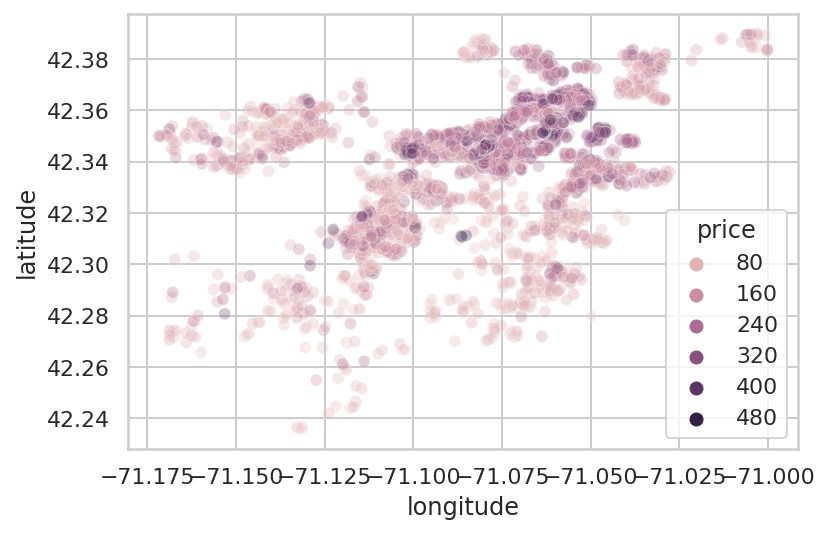

In [10]:
_ = sns.scatterplot(data = median_price_by_geoloc_filtered, 
                    x="longitude", 
                    y="latitude", 
                    hue="price",
                    alpha=0.3)

### Is there annual and weekly seasonality?

In [79]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['month'] = calendar['date'].dt.month
calendar['week'] = calendar['date'].dt.isocalendar().week
calendar['dow'] = calendar['date'].dt.weekday

print(f'First day: {calendar.date.min()}')
print(f'Last day: {calendar.date.max()}')

calendar_groupby_month = calendar[['month', 'price']].groupby(by=['month']).median() 
calendar_groupby_week = calendar[['week', 'price']].groupby(by=['week']).median()
calendar_groupby_dow = calendar[['dow', 'price']].groupby(by=['dow']).median()

#### Weekly Seasonality

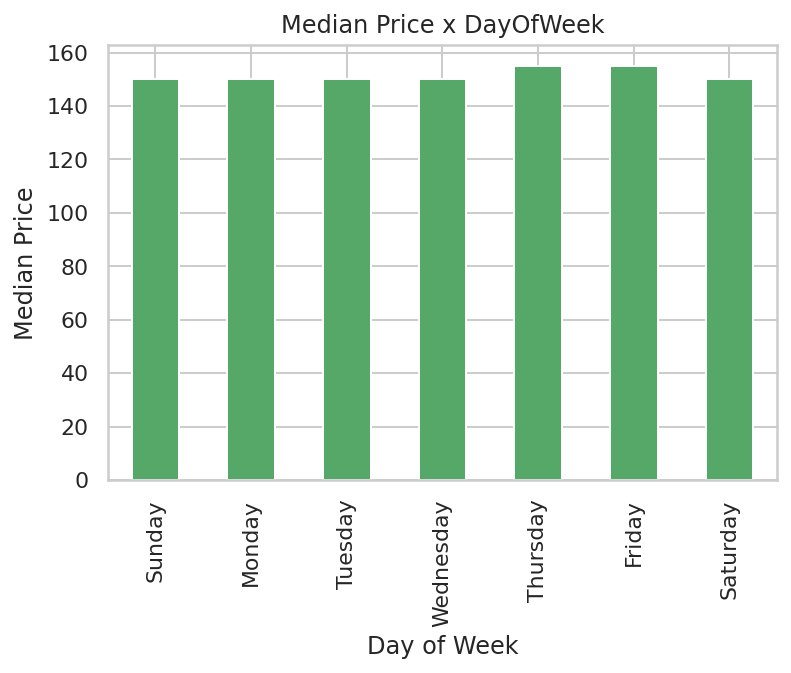

In [13]:
week = ['Sunday', 
        'Monday', 
        'Tuesday', 
        'Wednesday', 
        'Thursday',  
        'Friday', 
        'Saturday']

fig = calendar_groupby_dow.plot(kind = 'bar', 
                                color = 'g', 
                                xticks = np.arange(7), 
                                xlabel = 'Day of Week',
                                ylabel = 'Median Price',
                                title = 'Median Price x DayOfWeek',
                                legend = False)
_ = fig.set_xticklabels(week)

#### Annual seasonality

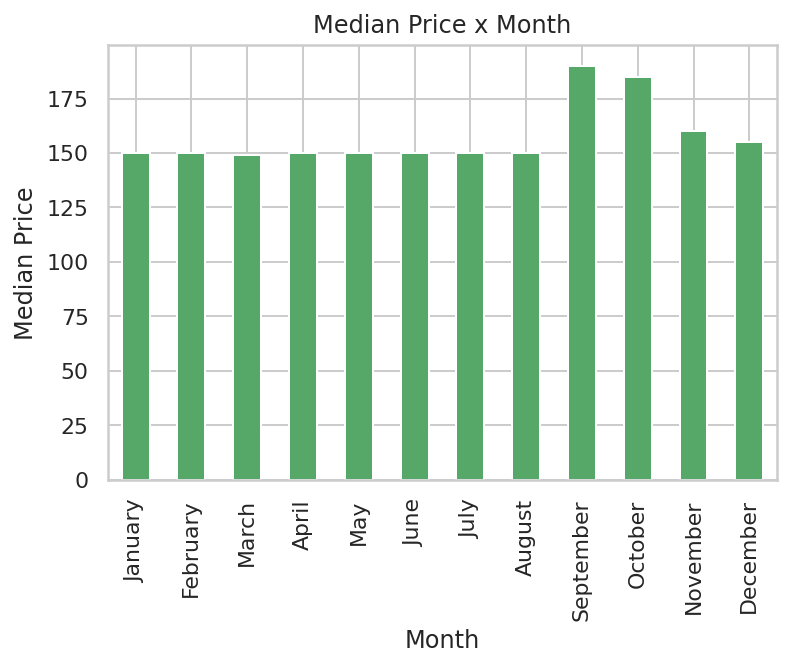

In [14]:
month = ['January', 
        'February', 
        'March', 
        'April', 
        'May', 
        'June', 
        'July', 
        'August', 
        'September', 
        'October', 
        'November', 
        'December'] 

fig = calendar_groupby_month.plot(kind = 'bar', 
                                  color = 'g', 
                                  xticks = np.arange(12), 
                                  xlabel = 'Month',
                                  ylabel = 'Median Price',
                                  title = 'Median Price x Month',
                                  legend = False)
_ = fig.set_xticklabels(month)

### What are the main characteristics of the property positively correlated with price?

In [15]:
listings['price'] = listings['price'].apply(price_to_numeric)
corr_price = listings.corr()['price'].sort_values(ascending = False) 

pos_corr_price = corr_price[corr_price > 0]
neg_corr_price = corr_price[corr_price < 0]

In [86]:
pos_corr_price.iloc[1:]

square_feet                       0.447795
accommodates                      0.437756
bedrooms                          0.385298
beds                              0.370013
bathrooms                         0.248234
guests_included                   0.211806
latitude                          0.196270
review_scores_location            0.193928
host_total_listings_count         0.171930
host_listings_count               0.171930
longitude                         0.165621
calculated_host_listings_count    0.161855
review_scores_cleanliness         0.146548
availability_30                   0.132100
availability_60                   0.112577
review_scores_rating              0.105651
availability_90                   0.098526
review_scores_accuracy            0.041204
availability_365                  0.036694
minimum_nights                    0.020054
review_scores_value               0.011834
review_scores_communication       0.003614
Name: price, dtype: float64

### What are the words in the description that are most related to price?

In [ ]:
some_text_features = listings[['price', 'description']].copy()

In [88]:
def text_pipe(description):
    """
    Arg: Description
    Return: Ad description text processed
    
    Function that receives ad description, remove stopwords and apply lemmatization 
    """
    tokenizer = word_tokenize
    stopwords_rem = stopwords.words('english')
    lemm = WordNetLemmatizer()
    word_list = tokenizer(description)
    word_list = [lemm.lemmatize(word.lower()) for word in word_list if word not in stopwords_rem and word.isalnum()]
    return ' '.join(word_list)

In [92]:
some_text_features.loc[:,('description_list_of_words')] = some_text_features['description'].apply(text_pipe)

countVec = CountVectorizer(analyzer = 'word', min_df = 0.05, max_df = 0.95)
x = v.fit_transform(some_text_features['description_list_of_words'])

df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names_out())
some_text_features.drop('description_list_of_words', axis=1, inplace=True)
res = pd.concat([some_text_features, df1], axis=1)
corr_text_price = res.corr()['price'].sort_values(ascending = False) 

In [96]:
principalWords = corr_text_price.iloc[1:10]

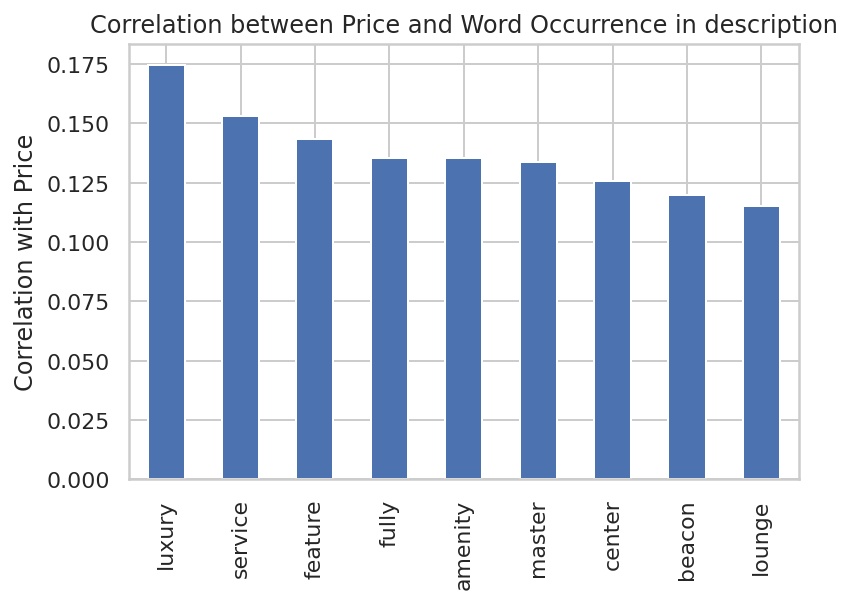

In [101]:
plotCorrPriceWords = principalWords.plot(kind='bar')
_ = plotCorrPriceWords.set_title('Correlation between Price and Word Occurrence in description')
_ = plotCorrPriceWords.set_ylabel('Correlation with Price')